# **이진 분류 모델 실습**


## **1. 환경준비**

### (1) 라이브러리 Import

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리와 평가를 위한 sklearn 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

# 파이토치 라이브러리
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) device 준비

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### (3) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [3]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :
    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # TensorDataset 생성: 텐서 데이터 세트로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [4]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # 전체 데이터 세트의 크기
    num_batches = len(dataloader) # 배치 크기
    tr_loss = 0

    model.train() # 학습 모드로 설정
    for x, y in dataloader: # 배치 단위로 로딩
        x, y = x.to(device), y.to(device) # 디바이스 지정

        # Feed Forward(오차 순전파)
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation(오차 역전파)
        loss.backward() # 역전파를 통해 각 파라미터에 대한 오차의 기울기 계산
        optimizer.step() # 옵티마이저가 모델의 파라미터를 업데이트
        optimizer.zero_grad() # 옵티마이저의 기울기값 초기화.

    tr_loss /= num_batches # 모든 배치의 오차 평균
    return tr_loss.item()

* 검증을 위한 함수

In [5]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval() # 모델을 평가 모드로 설정

    with torch.no_grad(): # 평가 과정에서 기울기를 계산하지 않도록 설정
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item() # 예측값 pred와 목푯값 y 사이의 오차 계산

    return eval_loss, pred

* 학습곡선

In [6]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list)+1)) # 에포크 수 계산
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.') # 학습 오차 그래프
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.') # 검증 오차 그래프
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

## **2. 데이터 전처리**

### (1) 데이터 로딩 및 준비

In [7]:
# 데이터 로딩
path = 'https://bit.ly/titanic_simple_csv'
data = pd.read_csv(path)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,Southampton
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,Cherbourg
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,Southampton
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,Southampton
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,Southampton


In [8]:
target = 'Survived'
features = ['Sex', 'Age', 'Fare']
x = data.loc[:, features]
y = data.loc[:, target]

In [9]:
x = pd.get_dummies(x, columns = ['Sex'], drop_first = True)
x.head()

,Age,Fare,Sex_male
0,22.0,7.2500,True
1,38.0,71.2833,False
2,26.0,7.9250,False
3,35.0,53.1000,False
4,35.0,8.0500,True


* 학습과 검증 데이터 분할 및 스케일링

In [10]:
# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3)

# 스케일링
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

# make_DataSet 입력을 위해 y_train, y_val를 넘파이 배열로 변환
y_train = y_train.values
y_val = y_val.values

### (2) 데이터 로더

In [11]:
# 데이터 로더 준비
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

In [13]:
#첫 번째 배치만 로딩해서 살펴보기
for x, y in train_loader:
    print(f'Shape of x [rows, columns]: {x.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of x [rows, columns]: torch.Size([32, 3])
Shape of y: torch.Size([32, 1]) torch.float32


## **3. 기본 모델링**

### (1) 모델 구조 설계

In [14]:
n_feature = x.shape[1]
# 모델 구조 설계
model = nn.Sequential( nn.Linear(n_feature, 1),
                nn.Sigmoid()
                ).to(device)

In [15]:
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.01)

### (2) 학습

In [16]:
epochs = 50
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
    # 리스트에 loss 추가
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}')

Epoch 1, train loss : 0.733635, val loss : 0.707684
Epoch 2, train loss : 0.700743, val loss : 0.675729
Epoch 3, train loss : 0.680846, val loss : 0.654114
Epoch 4, train loss : 0.665391, val loss : 0.637105
Epoch 5, train loss : 0.653997, val loss : 0.622607
Epoch 6, train loss : 0.642596, val loss : 0.610203
Epoch 7, train loss : 0.632665, val loss : 0.597626
Epoch 8, train loss : 0.621446, val loss : 0.588193
Epoch 9, train loss : 0.610962, val loss : 0.578301
Epoch 10, train loss : 0.604217, val loss : 0.570234
Epoch 11, train loss : 0.593306, val loss : 0.560793
Epoch 12, train loss : 0.588298, val loss : 0.552558
Epoch 13, train loss : 0.582272, val loss : 0.545105
Epoch 14, train loss : 0.573671, val loss : 0.540085
Epoch 15, train loss : 0.571828, val loss : 0.533508
Epoch 16, train loss : 0.563775, val loss : 0.529108
Epoch 17, train loss : 0.562471, val loss : 0.524341
Epoch 18, train loss : 0.555621, val loss : 0.519464
Epoch 19, train loss : 0.552124, val loss : 0.515789
Ep

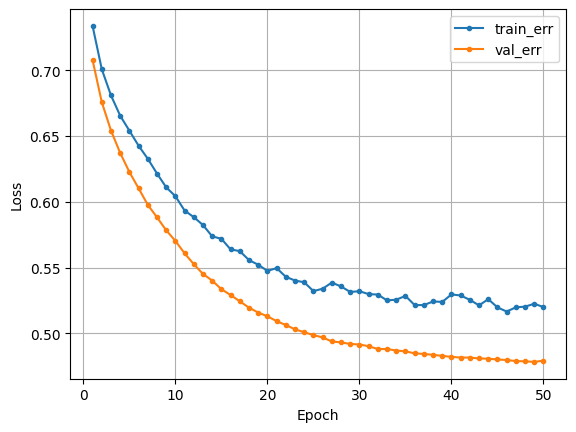

In [17]:
# 학습 곡선
dl_learning_curve(tr_loss_list, val_loss_list)

### (3) 예측 및 검증 평가

In [18]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
print(pred.numpy()[:5])

[[0.22256084]
 [0.21123526]
 [0.20489001]
 [0.21381   ]
 [0.20667133]]


* 확률값을 잘라 0과 1로 변환

In [23]:
pred = np.where(pred.numpy() > .5, 1, 0)
print(pred[:5])

[[0]
 [0]
 [0]
 [0]
 [0]]


* 성능 평가

In [24]:
print(confusion_matrix(y_val_ts.numpy(), pred))

[[114  21]
 [ 24  55]]


In [25]:
print(classification_report(y_val_ts.numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       135
         1.0       0.72      0.70      0.71        79

    accuracy                           0.79       214
   macro avg       0.77      0.77      0.77       214
weighted avg       0.79      0.79      0.79       214



## **3. 이진 분류 모델링 실습 2: 은닉층 추가**

### (1) 데이터 전처리

In [26]:
# 모델링에서 불필요한 열 제거
data = data.drop(['PassengerId', 'Name'], axis = 1)

# x, y분할
target = 'Survived'
x = data.drop(target, axis =1)
y = data.loc[:, target]

# 가변수화
x = pd.get_dummies(x, columns = ['Pclass', 'Sex', 'Embarked'], drop_first = True)

# train, val 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3)

# 스케일러 선언
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

# make_DataSet 입력을 위해 y_train, y_val을 넘파이 배열로 변환
y_train = y_train.values
y_val = y_val.values
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

### (2) 모델링

* 모델 설계: 전체 입력변수+은닉층 추가

In [27]:
n_feature = x.shape[1]
# 모델 구조 설계
model = nn.Sequential(nn.Linear(n_feature, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
            ).to(device)

loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.01)

* 학습

In [28]:
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
    # 리스트에 loss 추가
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}')

Epoch 1, train loss : 0.644917, val loss : 0.609976
Epoch 2, train loss : 0.575279, val loss : 0.561069
Epoch 3, train loss : 0.533181, val loss : 0.515881
Epoch 4, train loss : 0.503363, val loss : 0.490192
Epoch 5, train loss : 0.492274, val loss : 0.475620
Epoch 6, train loss : 0.482770, val loss : 0.465152
Epoch 7, train loss : 0.472794, val loss : 0.458754
Epoch 8, train loss : 0.468869, val loss : 0.451904
Epoch 9, train loss : 0.463490, val loss : 0.448795
Epoch 10, train loss : 0.462496, val loss : 0.445463
Epoch 11, train loss : 0.460247, val loss : 0.443165
Epoch 12, train loss : 0.458798, val loss : 0.439645
Epoch 13, train loss : 0.456921, val loss : 0.438154
Epoch 14, train loss : 0.457261, val loss : 0.433918
Epoch 15, train loss : 0.456528, val loss : 0.432610
Epoch 16, train loss : 0.455448, val loss : 0.432101
Epoch 17, train loss : 0.453712, val loss : 0.429928
Epoch 18, train loss : 0.455281, val loss : 0.428856
Epoch 19, train loss : 0.449095, val loss : 0.427279
Ep

* 학습 곡선

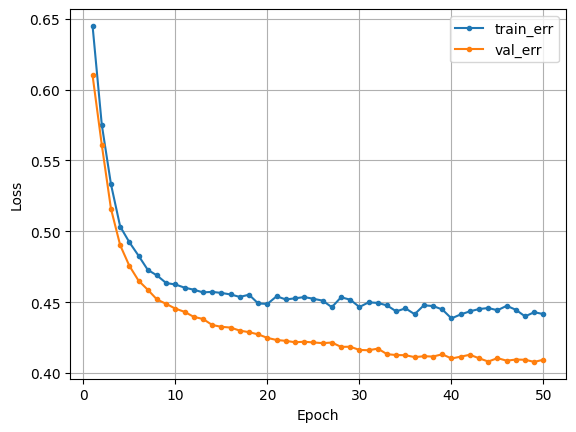

In [29]:
dl_learning_curve(tr_loss_list, val_loss_list)

* 검증 평가

In [30]:
# 예측
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

# 예측 확률값을 0.5 기준으로 반올림
pred = np.where(pred.numpy() > .5, 1, 0)

# 분류 모델 평가 지표 계산
print(classification_report(y_val_ts.numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.78      0.90      0.83       124
         1.0       0.82      0.64      0.72        90

    accuracy                           0.79       214
   macro avg       0.80      0.77      0.78       214
weighted avg       0.79      0.79      0.78       214



## **4. 이진 분류 모델링 실습 3: 직원 이직 예측**

### (1) 데이터 전처리

In [31]:
path = 'https://bit.ly/attri_csv'
data = pd.read_csv(path)
data.head()

,Attrition,Age,Department,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,Gender,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,33,Research & Development,7,3,817,3,Male,3,Married,11691,0,No,11,0,14,3,4,13
1,0,35,Research & Development,18,2,1412,3,Male,4,Single,9362,2,No,11,0,10,2,3,2
2,0,42,Research & Development,6,3,1911,3,Male,1,Married,13348,9,No,13,1,18,3,4,13
3,0,46,Sales,2,3,1204,3,Female,1,Married,17048,8,No,23,0,28,2,3,26
4,1,22,Research & Development,4,1,593,3,Male,3,Single,3894,5,No,16,0,4,3,3,2


In [32]:
target = 'Attrition'
x = data.drop([target, 'EmployeeNumber'], axis = 1)
y = data.loc[:, target]
print(x.shape)

(1175, 17)


In [33]:
cat_cols = ['Department', 'Education', 'EnvironmentSatisfaction', 'Gender', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'WorkLifeBalance']
x = pd.get_dummies(x, columns = cat_cols, drop_first=True)
x.shape

(1175, 28)

In [34]:
# train, val 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3)

# 스케일링
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

# make_DataSet 입력을 위해 y_train, y_val을 넘파이 배열로 변환
y_train = y_train.values
y_val = y_val.values

In [35]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

### (2) 모델링

In [36]:
from torchsummary import summary
n_feature = x.shape[1]
model = nn.Sequential(nn.Linear(n_feature, 16), nn.ReLU(),
            nn.Linear(16, 8), nn.ReLU(),
            nn.Linear(8, 1), nn.Sigmoid()
            ).to(device)
summary(model, input_size=(n_feature,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             464
              ReLU-2                   [-1, 16]               0
            Linear-3                    [-1, 8]             136
              ReLU-4                    [-1, 8]               0
            Linear-5                    [-1, 1]               9
           Sigmoid-6                    [-1, 1]               0
Total params: 609
Trainable params: 609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [37]:
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [38]:
epochs = 50
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}')

Epoch 1, train loss : 0.719056, val loss : 0.707977
Epoch 2, train loss : 0.697076, val loss : 0.685652
Epoch 3, train loss : 0.671898, val loss : 0.652921
Epoch 4, train loss : 0.635196, val loss : 0.611694
Epoch 5, train loss : 0.588775, val loss : 0.555339
Epoch 6, train loss : 0.526268, val loss : 0.480873
Epoch 7, train loss : 0.466836, val loss : 0.436915
Epoch 8, train loss : 0.441271, val loss : 0.428216
Epoch 9, train loss : 0.435537, val loss : 0.423783
Epoch 10, train loss : 0.424507, val loss : 0.419566
Epoch 11, train loss : 0.419436, val loss : 0.416224
Epoch 12, train loss : 0.410780, val loss : 0.412830
Epoch 13, train loss : 0.406800, val loss : 0.408867
Epoch 14, train loss : 0.397172, val loss : 0.405686
Epoch 15, train loss : 0.391061, val loss : 0.402770
Epoch 16, train loss : 0.381937, val loss : 0.400112
Epoch 17, train loss : 0.376426, val loss : 0.397746
Epoch 18, train loss : 0.368750, val loss : 0.395014
Epoch 19, train loss : 0.365151, val loss : 0.393879
Ep

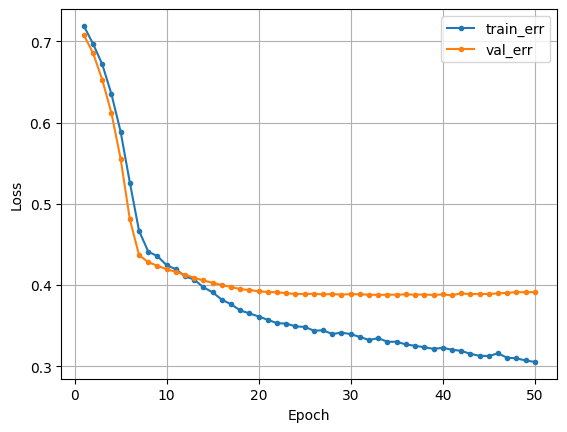

In [39]:
dl_learning_curve(tr_loss_list, val_loss_list)

In [40]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
pred = np.where(pred.numpy() > .5, 1, 0)

In [41]:
print(classification_report(y_val_ts.numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       298
         1.0       0.65      0.24      0.35        55

    accuracy                           0.86       353
   macro avg       0.76      0.61      0.63       353
weighted avg       0.84      0.86      0.83       353

